In [199]:
# pakages
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 資料前處理

In [106]:
# read the dataset
data_original = pd.read_csv('Covid Dataset.csv')
data_original.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,Yes,Yes,Yes,Yes,Yes,No,No,No,No,Yes,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Yes
1,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,...,Yes,No,No,No,Yes,Yes,No,No,No,Yes
2,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,...,Yes,Yes,Yes,No,No,No,No,No,No,Yes
3,Yes,Yes,Yes,No,No,Yes,No,No,Yes,Yes,...,No,No,Yes,No,Yes,Yes,No,No,No,Yes
4,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,...,No,Yes,No,Yes,No,Yes,No,No,No,Yes


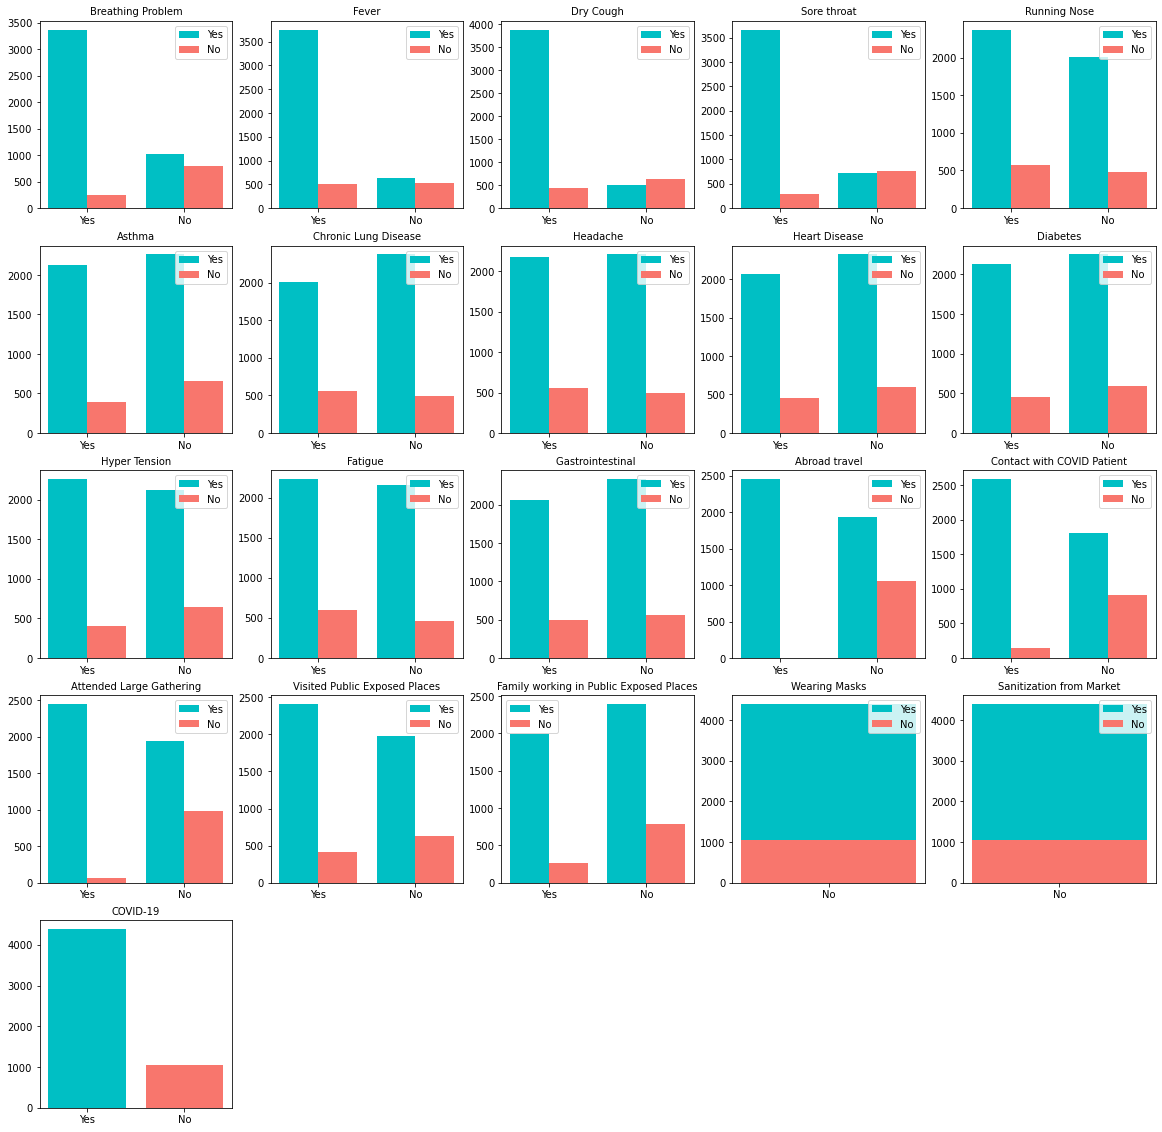

In [314]:
# data visualization

plt.figure(figsize = (20, 20))
column_names = list(data_original.columns.values)
for i in range(0, 21):
    if i == 18 or i == 19:
        plt.subplot(5, 5, i+1)
        xl = np.arange(1)
        x = list(set(data_original[column_names[i]]))
        y1 = [len(data_original[(data_original[column_names[i]] == j) & (data_original['COVID-19'] == 'Yes')]) for j in x]
        y2 = [len(data_original[(data_original[column_names[i]] == j) & (data_original['COVID-19'] == 'No')]) for j in x]
        plt.bar(xl, y1, width = 0.1, label = 'Yes', color = '#00BFC4')
        plt.bar(xl, y2, width = 0.1, label = 'No', color = '#F8766D')
    #         plt.ylabel('count')
        plt.xticks(xl, x)
        plt.legend()
        plt.title(column_names[i], fontsize = 10)
    elif i == 20:
        plt.subplot(5, 5, i+1)
        x = list(set(data_original[column_names[i]]))
        y = [len(data_original[data_original[column_names[i]] == j]) for j in x]
        plt.bar(x, y, color=['#00BFC4', '#F8766D'])
    #         plt.ylabel('count')
        plt.title(column_names[i], fontsize = 10)
    else:
        plt.subplot(5, 5, i+1)
        xl = np.arange(2)
        x = list(set(data_original[column_names[i]]))
        y1 = [len(data_original[(data_original[column_names[i]] == j) & (data_original['COVID-19'] == 'Yes')]) for j in x]
        y2 = [len(data_original[(data_original[column_names[i]] == j) & (data_original['COVID-19'] == 'No')]) for j in x]
        plt.bar(xl - 0.2, y1, width = 0.4, label = 'Yes', color = '#00BFC4')
        plt.bar(xl + 0.2, y2, width = 0.4, label = 'No', color = '#F8766D')
    #         plt.ylabel('count')
        plt.xticks(xl, x)
        plt.legend()
        plt.title(column_names[i], fontsize = 10)
plt.show()

In [107]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Breathing Problem                        5434 non-null   object
 1   Fever                                    5434 non-null   object
 2   Dry Cough                                5434 non-null   object
 3   Sore throat                              5434 non-null   object
 4   Running Nose                             5434 non-null   object
 5   Asthma                                   5434 non-null   object
 6   Chronic Lung Disease                     5434 non-null   object
 7   Headache                                 5434 non-null   object
 8   Heart Disease                            5434 non-null   object
 9   Diabetes                                 5434 non-null   object
 10  Hyper Tension                            5434 non-null   obj

In [181]:
# turn Yes、NO into 1、0
data = data_original.copy()
data.iloc[:, :-1] = data_original.iloc[:, :-1].replace(['Yes', 'No'], [1, 0])
data.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,1,1,1,1,1,0,0,0,0,1,...,1,1,0,1,0,1,1,0,0,Yes
1,1,1,1,1,0,1,1,1,0,0,...,1,0,0,0,1,1,0,0,0,Yes
2,1,1,1,1,1,1,1,1,0,1,...,1,1,1,0,0,0,0,0,0,Yes
3,1,1,1,0,0,1,0,0,1,1,...,0,0,1,0,1,1,0,0,0,Yes
4,1,1,1,1,1,0,1,1,1,1,...,0,1,0,1,0,1,0,0,0,Yes


# 資料切割為訓練集與測試集

In [120]:
data = shuffle(data) # randomize data
data.reset_index(inplace = True, drop = True)
x = data.drop(['COVID-19'], axis = 1)
y = data['COVID-19']

In [121]:
x.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market
0,1,1,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0
1,1,1,0,1,0,1,0,0,1,1,1,1,0,0,0,0,1,0,0,0
2,1,1,0,1,1,0,1,1,1,0,1,0,1,1,0,0,1,1,0,0
3,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,1,1,0,1,1,1,0,1,0,1,0,1,1,0,1,0,0,0,0,0


In [122]:
y.head()

0    Yes
1    Yes
2    Yes
3    Yes
4     No
Name: COVID-19, dtype: object

In [123]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 5)
x_train.head()
print('訓練集資料數量：', len(x_train))
print('測試集資料數量：', len(x_test))

訓練集資料數量： 4347
測試集資料數量： 1087


# 比較資料平衡方法：挑選其中最好的方法

# 1. SMOTE

In [142]:
# define decision tree model
clf = DecisionTreeClassifier()

# define random forest model
rf = RandomForestClassifier()

# define adaboost model
ada = AdaBoostClassifier(DecisionTreeClassifier())

# define logistic regression
lr = LogisticRegression()

# using smote to balance data (ratio of minority number and majority number is 1)
over = SMOTE(sampling_strategy = 1.0, random_state = 5)

# building steps
steps_clf = [('o', over), ('m', clf)]
steps_rf = [('o', over), ('m', rf)]
steps_ada = [('o', over), ('m', ada)]
steps_lr = [('o', over), ('m', lr)]

# building pipelines
pipeline_clf = Pipeline(steps = steps_clf)
pipeline_rf = Pipeline(steps = steps_rf)
pipeline_ada = Pipeline(steps = steps_ada)
pipeline_lr = Pipeline(steps = steps_lr)

# 10 folds
kf = KFold(n_splits = 10, shuffle = False)

In [143]:
# evaluate models

models = [pipeline_clf, pipeline_rf, pipeline_ada, pipeline_lr]
names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Logistic Regression']
precision = make_scorer(precision_score, pos_label = 'Yes')
recall = make_scorer(recall_score, pos_label = 'Yes')
f1 = make_scorer(f1_score, pos_label = 'Yes')
accuracy = make_scorer(accuracy_score)
evaluators = [precision, recall, f1, accuracy]
results = {}

for model, name in zip(models, names):
    results[name] = []
    for evaluator in evaluators:
        score = cross_val_score(model, x_train, y_train, scoring = evaluator, cv = kf, n_jobs = -1).mean()
#         print(score)
        results[name].append(score)

In [144]:
df1 = pd.DataFrame(results, index = ['precision', 'recall', 'f1 score', 'accuracy'])
print('Smote：')
df1

Smote：


,Decision Tree,Random Forest,AdaBoost,Logistic Regression
precision,0.999708,0.999708,0.999708,0.991116
recall,0.974543,0.974825,0.974825,0.946311
f1 score,0.986959,0.987103,0.987103,0.968120
accuracy,0.979296,0.979525,0.979525,0.950077


# 2. Under Sampling

In [145]:
# define decision tree model
clf = DecisionTreeClassifier()

# define random forest model
rf = RandomForestClassifier()

# define adaboost model
ada = AdaBoostClassifier(DecisionTreeClassifier())

# define logistic regression
lr = LogisticRegression()

# using smote to balance data (ratio of minority number and majority number is 1)
under = RandomUnderSampler(sampling_strategy = 1.0, random_state = 5)

# building steps
steps_clf = [('u', under), ('m', clf)]
steps_rf = [('u', under), ('m', rf)]
steps_ada = [('u', under), ('m', ada)]
steps_lr = [('u', under), ('m', lr)]

# building pipelines
pipeline_clf = Pipeline(steps = steps_clf)
pipeline_rf = Pipeline(steps = steps_rf)
pipeline_ada = Pipeline(steps = steps_ada)
pipeline_lr = Pipeline(steps = steps_lr)

# 10 folds
kf = KFold(n_splits = 10, shuffle = False)

In [146]:
# evaluate models

models = [pipeline_clf, pipeline_rf, pipeline_ada, pipeline_lr]
names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Logistic Regression']
precision = make_scorer(precision_score, pos_label = 'Yes')
recall = make_scorer(recall_score, pos_label = 'Yes')
f1 = make_scorer(f1_score, pos_label = 'Yes')
accuracy = make_scorer(accuracy_score)
evaluators = [precision, recall, f1, accuracy]
results = {}

for model, name in zip(models, names):
    results[name] = []
    for evaluator in evaluators:
        score = cross_val_score(model, x_train, y_train, scoring = evaluator, cv = kf, n_jobs = -1).mean()
#         print(score)
        results[name].append(score)

In [147]:
df2 = pd.DataFrame(results, index = ['precision', 'recall', 'f1 score', 'accuracy'])
print('Random under-sampling：')
df2

Random under-sampling：


,Decision Tree,Random Forest,AdaBoost,Logistic Regression
precision,1.000000,1.000000,1.000000,0.989330
recall,0.966585,0.973943,0.973153,0.939474
f1 score,0.982852,0.986943,0.986960,0.963619
accuracy,0.972624,0.979525,0.978835,0.943173


# 3. SMOTE + Under-sampling

In [148]:
# define decision tree model
clf = DecisionTreeClassifier()

# define random forest model
rf = RandomForestClassifier()

# define adaboost model
ada = AdaBoostClassifier(DecisionTreeClassifier())

# define logistic regression
lr = LogisticRegression()

# using smote to balance data (ratio of minority number and majority number is 1)
over = RandomUnderSampler(sampling_strategy = 0.5, random_state = 5)
under = RandomUnderSampler(sampling_strategy = 1.0, random_state = 5)

# building steps
steps_clf = [('o', over), ('u', under), ('m', clf)]
steps_rf = [('o', over), ('u', under), ('m', rf)]
steps_ada = [('o', over), ('u', under), ('m', ada)]
steps_lr = [('o', over), ('u', under), ('m', lr)]

# building pipelines
pipeline_clf = Pipeline(steps = steps_clf)
pipeline_rf = Pipeline(steps = steps_rf)
pipeline_ada = Pipeline(steps = steps_ada)
pipeline_lr = Pipeline(steps = steps_lr)

# 10 folds
kf = KFold(n_splits = 10, shuffle = False)

In [149]:
# evaluate models

models = [pipeline_clf, pipeline_rf, pipeline_ada, pipeline_lr]
names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Logistic Regression']
precision = make_scorer(precision_score, pos_label = 'Yes')
recall = make_scorer(recall_score, pos_label = 'Yes')
f1 = make_scorer(f1_score, pos_label = 'Yes')
accuracy = make_scorer(accuracy_score)
evaluators = [precision, recall, f1, accuracy]
results = {}

for model, name in zip(models, names):
    results[name] = []
    for evaluator in evaluators:
        score = cross_val_score(model, x_train, y_train, scoring = evaluator, cv = kf, n_jobs = -1).mean()
#         print(score)
        results[name].append(score)

In [150]:
df3 = pd.DataFrame(results, index = ['precision', 'recall', 'f1 score', 'accuracy'])
print('SMOTE + under-sampling：')
df3

SMOTE + under-sampling：


,Decision Tree,Random Forest,AdaBoost,Logistic Regression
precision,0.999708,0.999137,0.999142,0.991321
recall,0.968300,0.973408,0.973982,0.940035
f1 score,0.983755,0.986367,0.986673,0.964936
accuracy,0.974692,0.979066,0.979526,0.945249


# Overview

In [284]:
for name in names:
    print(name + '：\n')
    temp = pd.concat([df1[name], df2[name], df3[name]], axis = 1)
    temp.columns = ['SMOTE', 'Under-sampling', 'SMOTE + Under-sampling']
    print(temp, end = '\n\n')

Decision Tree：

              SMOTE  Under-sampling  SMOTE + Under-sampling
precision  0.999708        1.000000                0.999708
recall     0.974543        0.966585                0.968300
f1 score   0.986959        0.982852                0.983755
accuracy   0.979296        0.972624                0.974692

Random Forest：

              SMOTE  Under-sampling  SMOTE + Under-sampling
precision  0.999708        1.000000                0.999137
recall     0.974825        0.973943                0.973408
f1 score   0.987103        0.986943                0.986367
accuracy   0.979525        0.979525                0.979066

AdaBoost：

              SMOTE  Under-sampling  SMOTE + Under-sampling
precision  0.999708        1.000000                0.999142
recall     0.974825        0.973153                0.973982
f1 score   0.987103        0.986960                0.986673
accuracy   0.979525        0.978835                0.979526

Logistic Regression：

              SMOTE  Under-sampl

# 特徵選擇測試 (根據 overview，採用 SMOTE，並以相關係數選擇特徵)

In [184]:
data_corr = pd.concat([x_train, y_train], axis = 1)
data_corr.replace(['Yes', 'No'], [1, 0], inplace = True)
data_corr.reset_index(inplace = True, drop = True)
data_corr.tail()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
4342,1,1,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,1
4343,1,0,1,1,0,0,1,0,1,1,...,1,0,0,1,1,0,0,0,0,1
4344,1,1,1,0,1,1,1,0,0,0,...,1,0,1,1,0,0,0,0,0,1
4345,1,1,1,1,0,0,0,1,0,0,...,1,1,0,0,1,0,1,0,0,1
4346,1,1,1,1,1,0,1,0,0,1,...,0,0,1,1,1,0,1,0,0,1


<AxesSubplot:>

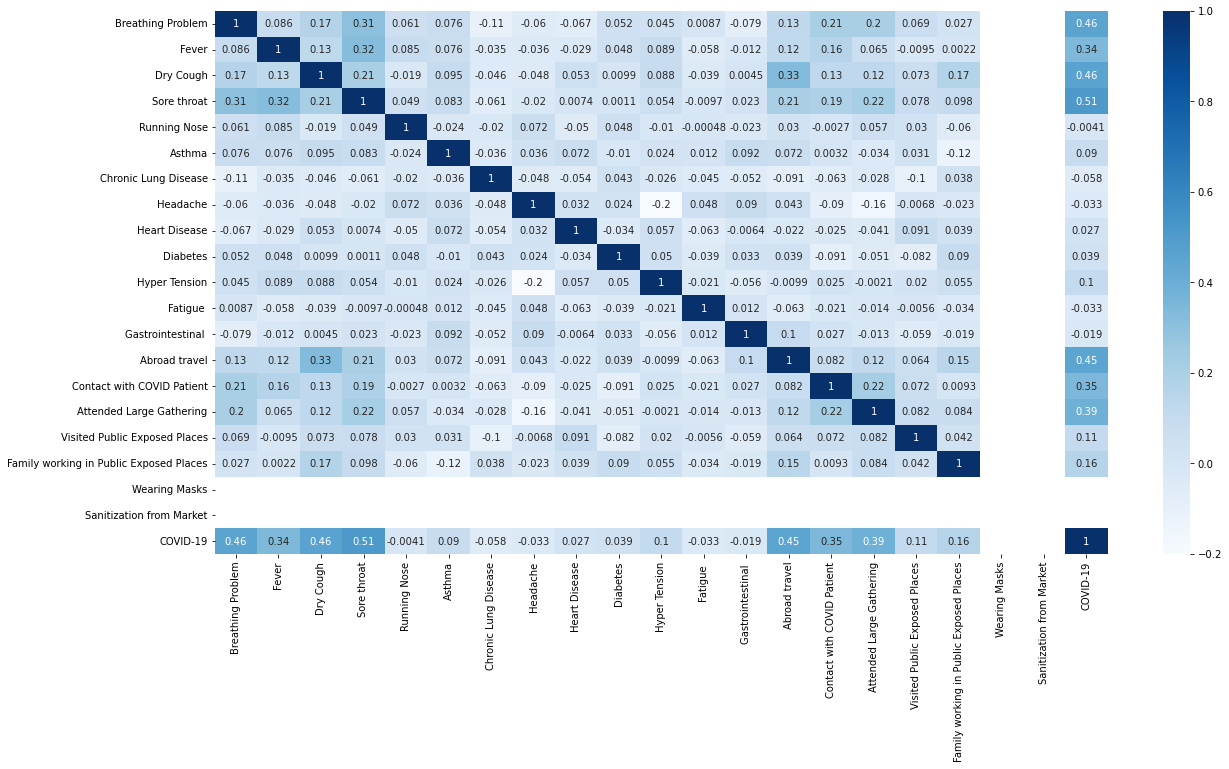

In [294]:
corr = data_corr.corr()
plt.rcParams['figure.figsize'] = (20, 10)
sns.heatmap(corr, cmap = 'Blues', annot = True)

In [185]:
corr.sort_values(by = 'COVID-19', ascending = False, inplace = True)
corr

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
COVID-19,0.455095,0.341120,0.461233,0.509614,-0.004144,0.089562,-0.058460,-0.033314,0.027132,0.038853,...,-0.032917,-0.018792,0.446494,0.347504,0.387318,0.108452,0.163986,NaN,NaN,1.000000
Sore throat,0.305349,0.316219,0.211161,1.000000,0.048738,0.083152,-0.061398,-0.019529,0.007412,0.001075,...,-0.009707,0.022901,0.207001,0.191530,0.220499,0.078385,0.097754,NaN,NaN,0.509614
Dry Cough,0.167014,0.127733,1.000000,0.211161,-0.019392,0.094775,-0.046078,-0.047824,0.052708,0.009940,...,-0.038886,0.004474,0.331268,0.127065,0.122956,0.072935,0.170934,NaN,NaN,0.461233
Breathing Problem,1.000000,0.085967,0.167014,0.305349,0.061344,0.076259,-0.107335,-0.060269,-0.067065,0.052114,...,0.008695,-0.079138,0.126271,0.209482,0.203430,0.068898,0.027448,NaN,NaN,0.455095
Abroad travel,0.126271,0.119694,0.331268,0.207001,0.030452,0.072439,-0.091061,0.043120,-0.021542,0.039047,...,-0.063417,0.100846,1.000000,0.081565,0.118547,0.063530,0.147549,NaN,NaN,0.446494
Attended Large Gathering,0.203430,0.065167,0.122956,0.220499,0.057075,-0.033974,-0.028396,-0.156517,-0.041027,-0.050872,...,-0.013911,-0.013081,0.118547,0.222834,1.000000,0.082308,0.084191,NaN,NaN,0.387318
Contact with COVID Patient,0.209482,0.163567,0.127065,0.191530,-0.002661,0.003171,-0.063336,-0.090282,-0.025255,-0.091026,...,-0.021094,0.026804,0.081565,1.000000,0.222834,0.071531,0.009281,NaN,NaN,0.347504
Fever,0.085967,1.000000,0.127733,0.316219,0.085159,0.075574,-0.034625,-0.036218,-0.029355,0.048477,...,-0.058353,-0.012019,0.119694,0.163567,0.065167,-0.009520,0.002227,NaN,NaN,0.341120
Family working in Public Exposed Places,0.027448,0.002227,0.170934,0.097754,-0.059932,-0.118499,0.037581,-0.023045,0.038601,0.090235,...,-0.034080,-0.018530,0.147549,0.009281,0.084191,0.041514,1.000000,NaN,NaN,0.163986
Visited Public Exposed Places,0.068898,-0.009520,0.072935,0.078385,0.029840,0.031387,-0.103025,-0.006769,0.090702,-0.081691,...,-0.005618,-0.059097,0.063530,0.071531,0.082308,1.000000,0.041514,NaN,NaN,0.108452


In [186]:
attributes = list(corr.index)
attributes.remove('COVID-19')
attributes

['Sore throat',
 'Dry Cough',
 'Breathing Problem',
 'Abroad travel',
 'Attended Large Gathering',
 'Contact with COVID Patient',
 'Fever',
 'Family working in Public Exposed Places',
 'Visited Public Exposed Places',
 'Hyper Tension',
 'Asthma',
 'Diabetes',
 'Heart Disease',
 'Running Nose',
 'Gastrointestinal ',
 'Fatigue ',
 'Headache',
 'Chronic Lung Disease',
 'Wearing Masks',
 'Sanitization from Market']

# 1. 根據相關係數，不斷刪除相關係數較低的特徵進行測試


In [203]:
# define decision tree model
clf = DecisionTreeClassifier()

# define random forest model
rf = RandomForestClassifier()

# define adaboost model
ada = AdaBoostClassifier(DecisionTreeClassifier())

# define logistic regression
lr = LogisticRegression()

# using smote to balance data (ratio of minority number and majority number is 1)
over = SMOTE(sampling_strategy = 1.0, random_state = 5)

# building steps
steps_clf = [('o', over), ('m', clf)]
steps_rf = [('o', over), ('m', rf)]
steps_ada = [('o', over), ('m', ada)]
steps_lr = [('o', over), ('m', lr)]

# building pipelines
pipeline_clf = Pipeline(steps = steps_clf)
pipeline_rf = Pipeline(steps = steps_rf)
pipeline_ada = Pipeline(steps = steps_ada)
pipeline_lr = Pipeline(steps = steps_lr)

# 10 folds
kf = KFold(n_splits = 10, shuffle = False)

In [205]:
# evaluate models

models = [pipeline_clf, pipeline_rf, pipeline_ada, pipeline_lr]
names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Logistic Regression']
# precision = make_scorer(precision_score, pos_label = 'Yes')
# recall = make_scorer(recall_score, pos_label = 'Yes')
f1 = make_scorer(f1_score, pos_label = 'Yes')
accuracy = make_scorer(accuracy_score)
f1_results = {}
acc_results = {}


for model, name in zip(models, names):
    f1_results[name] = []
    for i in range(20, 0, -1):
        score = cross_val_score(model, x_train[attributes[:i]], y_train, scoring = f1, cv = kf, n_jobs = -1).mean()
#         print(score)
        f1_results[name].append(score)

for model, name in zip(models, names):
    acc_results[name] = []
    for i in range(20, 0, -1):
        score = cross_val_score(model, x_train[attributes[:i]], y_train, scoring = accuracy, cv = kf, n_jobs = -1).mean()
#         print(score)
        acc_results[name].append(score)

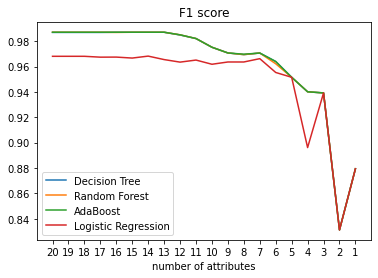

In [217]:
# ploting f1 score curve

for name in names:
    plt.plot(range(20, 0, -1), f1_results[name], label = name)

plt.xticks(range(20, 0, -1))
plt.xlim(21, 0)
plt.title('F1 score')
plt.xlabel('number of attributes')
plt.legend()
plt.show()

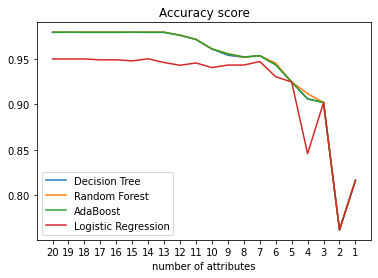

In [300]:
# ploting accuracy curve

plt.figure(figsize = (6, 4))
for name in names:
    plt.plot(range(20, 0, -1), acc_results[name], label = name)

plt.xticks(range(20, 0, -1))
plt.xlim(21, 0)
plt.title('Accuracy score')
plt.xlabel('number of attributes')
plt.legend()
plt.show()

# 2. 根據相關係數，不斷加入相關係數較高的特徵進行測試

In [219]:
# define decision tree model
clf = DecisionTreeClassifier()

# define random forest model
rf = RandomForestClassifier()

# define adaboost model
ada = AdaBoostClassifier(DecisionTreeClassifier())

# define logistic regression
lr = LogisticRegression()

# using smote to balance data (ratio of minority number and majority number is 1)
over = SMOTE(sampling_strategy = 1.0, random_state = 5)

# building steps
steps_clf = [('o', over), ('m', clf)]
steps_rf = [('o', over), ('m', rf)]
steps_ada = [('o', over), ('m', ada)]
steps_lr = [('o', over), ('m', lr)]

# building pipelines
pipeline_clf = Pipeline(steps = steps_clf)
pipeline_rf = Pipeline(steps = steps_rf)
pipeline_ada = Pipeline(steps = steps_ada)
pipeline_lr = Pipeline(steps = steps_lr)

# 10 folds
kf = KFold(n_splits = 10, shuffle = False)

In [227]:
# evaluate models

models = [pipeline_clf, pipeline_rf, pipeline_ada, pipeline_lr]
names = ['Decision Tree', 'Random Forest', 'AdaBoost', 'Logistic Regression']
# precision = make_scorer(precision_score, pos_label = 'Yes')
# recall = make_scorer(recall_score, pos_label = 'Yes')
f1 = make_scorer(f1_score, pos_label = 'Yes')
accuracy = make_scorer(accuracy_score)
reverse_attributes = attributes.copy()
reverse_attributes.reverse()
f1_results_another = {}
acc_results_another = {}


for model, name in zip(models, names):
    f1_results_another[name] = []
    for i in range(1, 21, 1):
        score = cross_val_score(model, x_train[reverse_attributes[:i]], y_train, scoring = f1, cv = kf, n_jobs = -1).mean()
#         print(score)
        f1_results_another[name].append(score)

for model, name in zip(models, names):
    acc_results_another[name] = []
    for i in range(1, 21, 1):
        score = cross_val_score(model, x_train[reverse_attributes[:i]], y_train, scoring = accuracy, cv = kf, n_jobs = -1).mean()
#         print(score)
        acc_results_another[name].append(score)

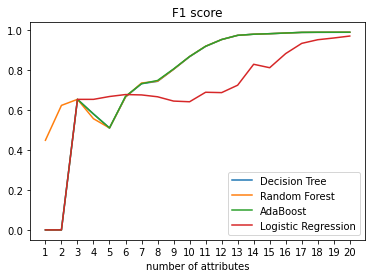

In [230]:
# ploting f1 score curve

for name in names:
    plt.plot(range(1, 21, 1), f1_results_another[name], label = name)

plt.xticks(range(1, 21))
# plt.xlim(21, 0)
plt.title('F1 score')
plt.xlabel('number of attributes')
plt.legend()
plt.show()

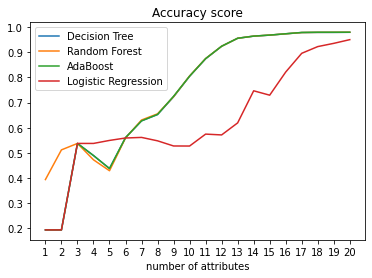

In [302]:
# ploting accuracy curve

plt.figure(figsize = (6, 4))
for name in names:
    plt.plot(range(1, 21, 1), acc_results_another[name], label = name)

plt.xticks(range(1, 21))
# plt.xlim(21, 0)
plt.title('Accuracy score')
plt.xlabel('number of attributes')
plt.legend()
plt.show()

# 根據以上結果，選擇 RF、AdaBoost 模型及全部特徵，預測測試集

In [279]:
# define random forest model
rf = RandomForestClassifier()

# fit the smoted data
over = SMOTE(sampling_strategy = 1.0, random_state = 5)
x_train_res, y_train_res = over.fit_resample(x_train, y_train)
rf.fit(x_train_res, y_train_res)

# predict the data
predicts = rf.predict(x_test)

print('Random Forest Model performance on test dataset：\n')
print('Precision：', precision_score(predicts, y_test, pos_label = 'Yes'))
print('Recall：', recall_score(predicts, y_test, pos_label = 'Yes'))
print('F1 score：', f1_score(predicts, y_test, pos_label = 'Yes'))
print('Accuracy：', accuracy_score(predicts, y_test))

print('\n')

# define AdaBoost model
ada = AdaBoostClassifier(DecisionTreeClassifier())

# fit the smoted data
over = SMOTE(sampling_strategy = 1.0, random_state = 5)
x_train_res, y_train_res = over.fit_resample(x_train, y_train)
ada.fit(x_train_res, y_train_res)

# predict the data
predicts = ada.predict(x_test)

print('AdaBoost Model performance on test dataset：\n')
print('Precision：', precision_score(predicts, y_test, pos_label = 'Yes'))
print('Recall：', recall_score(predicts, y_test, pos_label = 'Yes'))
print('F1 score：', f1_score(predicts, y_test, pos_label = 'Yes'))
print('Accuracy：', accuracy_score(predicts, y_test))

Random Forest Model performance on test dataset：

Precision： 0.9817559863169898
Recall： 1.0
F1 score： 0.9907940161104718
Accuracy： 0.985280588776449


AdaBoost Model performance on test dataset：

Precision： 0.9817559863169898
Recall： 1.0
F1 score： 0.9907940161104718
Accuracy： 0.985280588776449


# 分群：探究高準確率原因

In [253]:
# pakages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [264]:
data_cluster = pd.read_csv('Covid Dataset.csv')
data_cluster.tail()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
5429,Yes,Yes,No,Yes,Yes,Yes,Yes,No,No,No,...,Yes,Yes,No,No,No,No,No,No,No,Yes
5430,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,...,Yes,No,No,No,No,No,No,No,No,Yes
5431,Yes,Yes,Yes,No,No,No,No,No,Yes,No,...,No,No,No,No,No,No,No,No,No,No
5432,Yes,Yes,Yes,No,Yes,No,No,Yes,Yes,No,...,No,No,No,No,No,No,No,No,No,No
5433,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,...,Yes,No,No,No,No,No,No,No,No,No


In [265]:
data_cluster.replace(['Yes', 'No'], [1, 0], inplace = True)
data_cluster.tail()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
5429,1,1,0,1,1,1,1,0,0,0,...,1,1,0,0,0,0,0,0,0,1
5430,1,1,1,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
5431,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5432,1,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5433,1,1,1,0,1,1,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [266]:
# implement SMOTE on clustering data to see the reason why the accuray of the classification of smoted data is so high

x = data_cluster.drop('COVID-19', axis = 1)
y = data_cluster['COVID-19']
sm = SMOTE(sampling_strategy = 1.0)
x_res, y_res = sm.fit_resample(x, y)
y_res

0       1
1       1
2       1
3       1
4       1
       ..
8761    0
8762    0
8763    0
8764    0
8765    0
Name: COVID-19, Length: 8766, dtype: int64

In [267]:
# concat attributes and label

data_smoted = pd.concat([x_res, y_res], axis = 1)
data_smoted.tail()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
8761,0,1,0,1,1,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
8762,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8763,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
8764,0,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,1,0,0,0,0
8765,0,0,0,0,1,0,0,1,1,0,...,1,0,0,0,0,1,1,0,0,0


In [268]:
# To analyze cluster results, drop Wearing Masks & Sanitization from Market because they have only one unique value

data_smoted.drop(columns = ['Wearing Masks', 'Sanitization from Market'], inplace = True)
data_smoted.tail()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,COVID-19
8761,0,1,0,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0
8762,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
8763,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,1,0,0
8764,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,0
8765,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,1,0


Text(0, 0.5, 'Inertia')

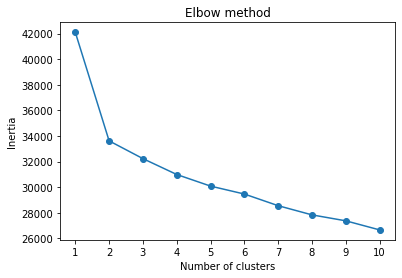

In [321]:
# Kmeans - elbow method

plt.figure(figsize = (6, 4))
distortions = []
for i in range(1, 11):
    kmeans_fit = KMeans(n_clusters = i).fit(data_smoted)
    distortions.append(kmeans_fit.inertia_)
plt.plot(range(1, 11), distortions, marker = 'o')
# plt.title('Inertia')
plt.xlabel('Number of clusters')
plt.xticks(range(1, 11))
plt.title('Elbow method')
plt.ylabel('Inertia')

Text(0, 0.5, 'Inertia')

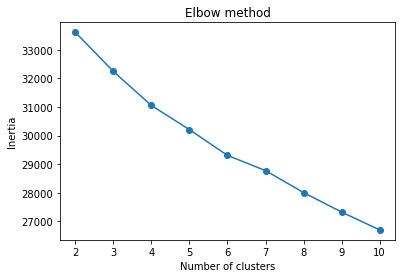

In [316]:
# Kmeans - elbow method

plt.figure(figsize = (6, 4))
distortions = []
for i in range(2, 11):
    kmeans_fit = KMeans(n_clusters = i).fit(data_smoted)
    distortions.append(kmeans_fit.inertia_)
plt.plot(range(2, 11), distortions, marker = 'o')
# plt.title('Inertia')
plt.xlabel('Number of clusters')
plt.title('Elbow method')
plt.ylabel('Inertia')

Text(0.5, 1.0, 'Silhouette score')

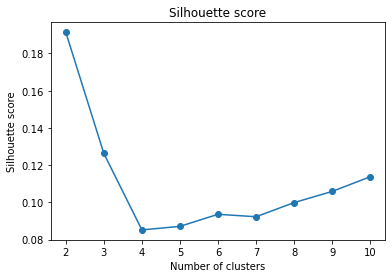

In [317]:
# Kmeans - silhouette score

plt.figure(figsize = (6, 4))
silhouette_avg = []
for i in range(2, 11):
    kmeans_fit = KMeans(n_clusters = i).fit(data_smoted)
    silhouette_avg.append(silhouette_score(data_smoted, kmeans_fit.labels_))
plt.plot(range(2, 11), silhouette_avg, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')

In [271]:
# According to the silhouette score results, we choose 2 as the number of clusters to cluster the data

kmeans_fit = KMeans(n_clusters = 2).fit(data_smoted)
kmeans_fit.labels_

array([0, 0, 0, ..., 0, 1, 1])

In [272]:
# put cluster result back into dataset

data_smoted['Cluster'] = kmeans_fit.labels_
data_smoted.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,Hyper Tension,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,COVID-19,Cluster
0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,1,1,0
1,1,1,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,1,0
2,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,0
3,1,1,1,0,0,1,0,0,1,1,0,0,0,1,0,1,1,0,1,0
4,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,0,1,0,1,0


In [274]:
# analysis the attributes and label on each cluster

attributes_label = list(data_smoted.columns)
attributes_label.remove('Cluster')
cluster_numbers = set(data_smoted['Cluster'])
cluster_results = {}

for n in cluster_numbers:
    cluster_column = 'Cluster ' + str(n)
    cluster_results[cluster_column] = []
    for item in attributes_label:
        temp_df = data_smoted[data_smoted['Cluster'] == n]
        cluster_results[cluster_column].append(temp_df[item].mean())

cluster_analysis = pd.DataFrame(cluster_results, index = attributes_label)
print(cluster_analysis)

                                         Cluster 0  Cluster 1
Breathing Problem                         0.777680   0.204868
Fever                                     0.862153   0.471172
Dry Cough                                 0.888840   0.389887
Sore throat                               0.843846   0.235350
Running Nose                              0.558227   0.526701
Asthma                                    0.491398   0.353970
Chronic Lung Disease                      0.453022   0.543951
Headache                                  0.503529   0.524338
Heart Disease                             0.489634   0.426276
Diabetes                                  0.480150   0.441635
Hyper Tension                             0.532642   0.353970
Fatigue                                   0.514336   0.559310
Gastrointestinal                          0.464711   0.466682
Abroad travel                             0.539479   0.001181
Contact with COVID Patient                0.582267   0.127836
Attended